In [1]:
import ROOT
from T2KStyle import T2KStyle

Welcome to JupyROOT 6.20/06
Style for publication/paper


In [2]:
%jsroot on
c = ROOT.TCanvas('c', '', 800, 600)
cl = ROOT.TCanvas('cl', '', 1600, 1200)
cw = ROOT.TCanvas('c2', '', 1600, 600)
cw3 = ROOT.TCanvas('c3', '', 2400, 600)

In [3]:
path = '~/LXPLUS/DESY_testbeam/hs_ind_freec/'
# path = '~/DATA/hs_para3/'

it = 9

file = [#ROOT.TFile(path + f's_200_430_02T_iter{it}.root'),
        #ROOT.TFile(path + f's_200_480_02T_iter{it}.root'),
        ROOT.TFile(path + f's_412_430_02T_iter{it}.root'),
        #ROOT.TFile(path + f's_412_480_02T_iter{it}.root')
       ]

In [ ]:
path = '~/DATA/z_scan/'

file = [ROOT.TFile(path + 'z_360_275_200_0T_all_iter9.root'),
        ROOT.TFile(path + 'z_360_275_200_02T_all_iter9.root'),
        ROOT.TFile(path + 'z_360_275_412_0T_all_iter9.root'),
        ROOT.TFile(path + 'z_360_275_412_02T_all_iter9.root')
       ]

## Process the data

In [4]:
ax = ROOT.TAxis(50, -0.035, 0.015)
res = []
for f_id, fi in enumerate(file[:]):
    res.append([])
    for col in range(36):
        res[f_id].append([])
        for i in range(50):
            res[f_id][col].append(ROOT.TH1F(f'x_scan_{f_id}_{col}_{i}', '', 200, -0.002, 0.002))
    n = 0
    for entry in fi.outtree:
#         print(entry.pad_y[0], entry.pad_y[33*10])
#         if entry.pad_y[0] != 15 or entry.pad_y[33*10] != 15:
#             continue
        n += 1
#         if abs(entry.track_pos[0]) > 0.0001:
#             continue
#         if entry.mom > 0.:
#             continue
        
        for i in range(len(entry.track_pos)):
            if entry.qfrac[i*10] < 0:
                continue
            # uncomment this if you want just one column. 
    #         if entry.pad_x[i*10] != 5:
    #             continue
            b = ax.FindBin(entry.track_pos[i]) - 1
            if b >= 50:
                continue
            res[f_id][entry.pad_x[i*10]][b].Fill(entry.residual[i])
    print(f'file {f_id} is done', n)

file 0 is done 136870


## Plot many columns

### Statistics

Warning in <TFile::Append>: Replacing existing TH1: h_max (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_min (Potential memory leak).
Info in <TCanvas::Print>: pdf file bias_all.pdf has been created


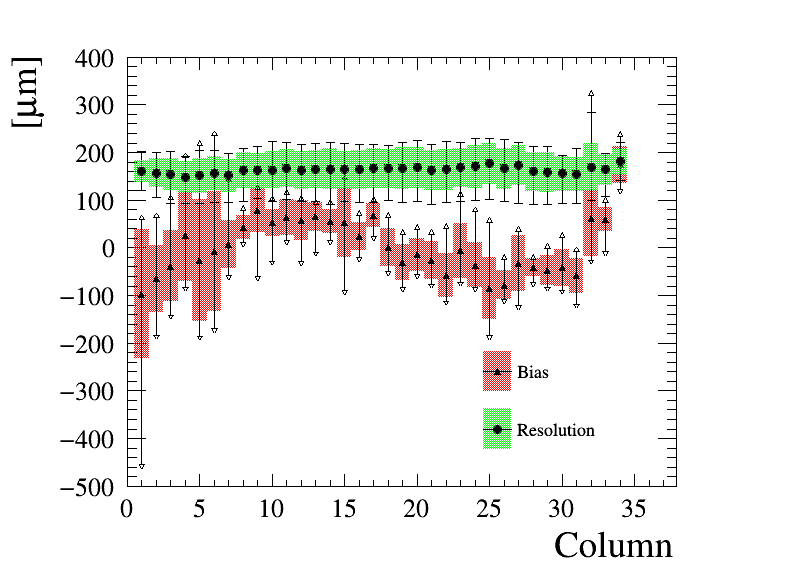

In [17]:
%jsroot off
ran = 0.003
ROOT.gPad.SetGridx(0)
ROOT.gPad.SetGridy(0)
gr_max = ROOT.TGraphAsymmErrors()
gr_rms = ROOT.TGraphAsymmErrors()

gr_max_res = ROOT.TGraphAsymmErrors()
gr_rms_res = ROOT.TGraphAsymmErrors()

h_max = ROOT.TH1F('h_max', '', 50, -0.035, 0.015)
h_min = ROOT.TH1F('h_min', '', 50, -0.035, 0.015)

file_id = 0

start = -0.015
end = 0.005
# start = -0.0045
# end = -0.0005

for col in range(36):
    maxim = -1e6
    minim = 1e6
    maxim_pos = -999
    minim_pos = -999
    mean = 0.
    n = 0
    maxim_res = -1e6
    minim_res = 1e6
    mean_res = 0.
    for i in range(ax.FindBin(start)-1, ax.FindBin(end)-1):
        if res[file_id][col][i].Integral() == 0:
            continue
        res[file_id][col][i].Fit('gaus', 'Q', '', -1.*ran, ran)
        f = res[file_id][col][i].GetFunction('gaus')
        
        bias = 1e6*f.GetParameter(1)
        resol = 1e6*f.GetParameter(2)
        mean += bias
        mean_res += resol
        n += 1
        if bias > maxim: maxim = bias; maxim_pos = ax.GetBinCenter(i+1)
        if bias < minim: minim = bias; minim_pos = ax.GetBinCenter(i+1)
        if resol > maxim_res: maxim_res = resol
        if resol < minim_res: minim_res = resol
    if n == 0:
        continue
    mean /= n
    mean_res /= n
    rms = 0
    rms_res = 0
    for i in range(ax.FindBin(start)-1, ax.FindBin(end)-1):
        f = res[file_id][col][i].GetFunction('gaus')
        try:
            bias = 1e6*f.GetParameter(1)
            resol = 1e6*f.GetParameter(2)
            rms += (bias - mean) ** 2
            rms_res += (resol - mean_res) ** 2
        except:
            continue
    rms = rms**0.5
    rms /= n**0.5
    rms_res = rms_res**0.5
    rms_res /= n**0.5
    gr_max.SetPoint(gr_max.GetN(), col, mean)
    gr_max.SetPointEYhigh(gr_max.GetN()-1, maxim - mean)
    gr_max.SetPointEYlow(gr_max.GetN()-1, mean - minim)
    gr_rms.SetPoint(gr_rms.GetN(), col, mean)
    gr_rms.SetPointEYhigh(gr_rms.GetN()-1, rms)
    gr_rms.SetPointEYlow(gr_rms.GetN()-1, rms)
    gr_rms.SetPointEXhigh(gr_rms.GetN()-1, 0.5)
    gr_rms.SetPointEXlow(gr_rms.GetN()-1, 0.5)
    
    gr_max_res.SetPoint(gr_max_res.GetN(), col, mean_res)
    gr_max_res.SetPointEYhigh(gr_max_res.GetN()-1, maxim_res - mean_res)
    gr_max_res.SetPointEYlow(gr_max_res.GetN()-1, mean_res - minim_res)
    gr_rms_res.SetPoint(gr_rms_res.GetN(), col, mean_res)
    gr_rms_res.SetPointEYhigh(gr_rms_res.GetN()-1, rms_res)
    gr_rms_res.SetPointEYlow(gr_rms_res.GetN()-1, rms_res)
    gr_rms_res.SetPointEXhigh(gr_rms_res.GetN()-1, 0.5)
    gr_rms_res.SetPointEXlow(gr_rms_res.GetN()-1, 0.5)
    
    h_max.Fill(maxim_pos)
    h_min.Fill(minim_pos)
c.cd()


lg = ROOT.TLegend(0.6, 0.2, 0.8, 0.4)
# gr_max.SetMarkerSize(0.001)
gr_rms.GetXaxis().SetTitle("Column")
gr_rms.GetYaxis().SetTitle("[#mum]")
gr_rms.GetYaxis().SetRangeUser(-500, 400)

gr_max.SetMarkerStyle(22)
gr_rms.SetMarkerStyle(22)
gr_rms.SetMarkerColor(ROOT.kBlack);
gr_rms.SetFillColor(2);
gr_rms.SetFillStyle(3001);
gr_rms.Draw('a2')
gr_max.Draw("same p|>")
lg.AddEntry(gr_rms, 'Bias')

gr_max_res.SetMarkerStyle(23)
gr_max_res.Draw("same p")
gr_rms_res.SetFillColor(3);
gr_rms_res.SetFillStyle(3001);
gr_rms_res.Draw('same p2')
lg.AddEntry(gr_rms_res, 'Resolution')

# ROOT.gPad.SetGrid(0)
lg.Draw()
c.Draw()
c.Print('bias_all.pdf')

In [ ]:
c.cd()
hs = ROOT.THStack('hs', '')
h_min.SetLineColor(ROOT.kRed)
hs.Add(h_max)
hs.Add(h_min)
hs.Draw('histo nostack')
c.Draw()

### Overlap

Info in <TCanvas::Print>: pdf file bias.pdf has been created


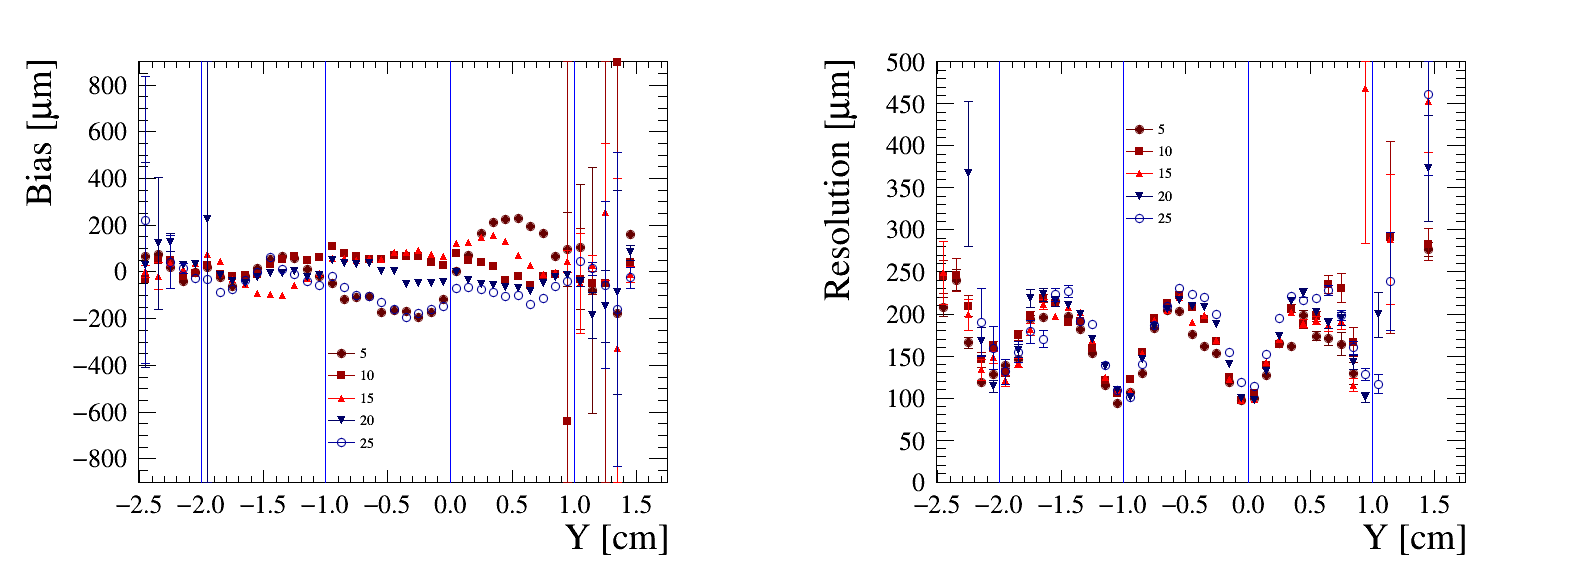

In [15]:
# ran = 0.003
cw.Clear()
cw.Divide(2)
ROOT.gPad.SetGridx(0)
ROOT.gPad.SetGridy(0)
file_id = 0
resol_gr = []
bias_gr = []
columns = [5, 10, 15, 20, 25]
# columns = [5, 11, 14, 16]
colors = [ROOT.kRed+3, ROOT.kRed+2, ROOT.kRed, 
         ROOT.kBlue+3, ROOT.kBlue+2, ROOT.kBlue,
         ROOT.kGreen+3, ROOT.kGreen+2, ROOT.kGreen]
for i in range(len(columns)):
    bias_gr.append(ROOT.TGraphErrors())
    bias_gr[-1].SetLineColor(colors[i])
    bias_gr[-1].SetMarkerColor(colors[i])
    bias_gr[-1].SetTitle(str(columns[i]))
    resol_gr.append(ROOT.TGraphErrors())
    resol_gr[-1].SetLineColor(colors[i])
    resol_gr[-1].SetMarkerColor(colors[i])
    resol_gr[-1].SetTitle(str(columns[i]))
for col in range(36):
    for i in range(50):
        if res[file_id][col][i].Integral() == 0:
            continue
        res[file_id][col][i].Fit('gaus', 'Q', '', -1.*ran, ran)
        f = res[file_id][col][i].GetFunction('gaus')

        if col in columns:
            bias_gr[columns.index(col)].SetPoint(bias_gr[columns.index(col)].GetN(), ax.GetBinCenter(i+1)*100, 1e6*f.GetParameter(1))
            bias_gr[columns.index(col)].SetPointError(bias_gr[columns.index(col)].GetN()-1, 0, 1e6*f.GetParError(1))
            resol_gr[columns.index(col)].SetPoint(resol_gr[columns.index(col)].GetN(), ax.GetBinCenter(i+1)*100, 1e6*f.GetParameter(2))
            resol_gr[columns.index(col)].SetPointError(resol_gr[columns.index(col)].GetN()-1, 0, 1e6*f.GetParError(2))


mg = ROOT.TMultiGraph()
mg2 = ROOT.TMultiGraph()
for i in range(len(columns)):
    bias_gr[i].SetMarkerStyle(20+i)
    resol_gr[i].SetMarkerStyle(20+i)
    mg.Add(bias_gr[i])
    mg2.Add(resol_gr[i])
cw.Clear()
cw.Divide(2)   
cw.cd(1)
mg.Draw("ap")
mg.GetXaxis().SetRangeUser(-2.5, 4)
mg.GetYaxis().SetTitle("Bias [#mum]")
mg.GetXaxis().SetTitle("Y [cm]")
mg.GetYaxis().SetRangeUser(-900, 900)
ROOT.gPad.BuildLegend(0.4, 0.2, 0.6, 0.4)
ROOT.gPad.SetGridx(0)
ROOT.gPad.SetGridy(0)
l = []
for i in range(1, 5):
    l.append(ROOT.TLine(-3+i*1, -900., -3+i*1, 900.));
    l[-1].SetLineColor(ROOT.kBlue)
    l[-1].Draw()
cw.cd(2)
mg2.Draw("ap")
mg2.GetXaxis().SetRangeUser(-2.5, 4)
mg2.GetYaxis().SetTitle("Resolution [#mum]")
mg2.GetXaxis().SetTitle("Y [cm]")
mg2.GetYaxis().SetRangeUser(0., 500.)
ROOT.gPad.BuildLegend(0.4, 0.6, 0.6, 0.8)
ROOT.gPad.SetGridx(0)
ROOT.gPad.SetGridy(0)
l2 = []
for i in range(1, 5):
    l2.append(ROOT.TLine(-3+i*1, 0., -3+i*1, 500.));
    l2[-1].SetLineColor(ROOT.kBlue)
    l2[-1].Draw()

cw.Draw()
cw.Print("bias.pdf")

### PRF fit

In [ ]:
cw.Clear()
cw.Divide(2)

formula = "[0]*(1+[1]*x*x + [2] * x*x*x*x) / (1+[3]*x*x+[4]*x*x*x*x)";
formula = "[0]*(1+[1]*(x-[5])*(x-[5]) + [2] * (x-[5])*(x-[5])*(x-[5])*(x-[5])) / (1+[3]*(x-[5])*(x-[5])+[4]*(x-[5])*(x-[5])*(x-[5])*(x-[5]))"
PRF_function  = ROOT.TF1("PRF_function",
                         formula,
                         -0.027, 0.027);

file_id = 2
h1 = ROOT.TH2F('h1', '', 180, -0.027, 0.027, 100, 0., 1.)
h2 = ROOT.TH2F('h2', '', 180, -0.027, 0.027, 100, 0., 1.)

cw.cd(1)
file[file_id].outtree.Project('h1', 'qfrac:dx', 'pad_x == 5')
h1.Fit('PRF_function', 'Q')
h1.Fit('PRF_function', 'Q')
h1.Fit('PRF_function', '')
h1.GetXaxis().SetTitle("X_{track} - X_{pad} [m]")
h1.GetYaxis().SetTitle("Q_{pad} / Q_{cluster}")
h1.Draw('colz')

cw.cd(2)
file[file_id].outtree.Project('h2', 'qfrac:dx', 'pad_x == 12')
h2.Fit('PRF_function', 'Q')
h2.Fit('PRF_function', '')
h2.Draw('colz')

cw.Draw()

## Print the bias

In [ ]:
ran = 0.003
print('{', end='')
for col in range(36):
    print(', {', end='')
    for i in range(50):
        if res[col][i].Integral() == 0:
            print(col, i, 0, sep='\t')
            print('0,', end='')
            continue
        res[col][i].Fit('gaus', 'Q', '', -1.*ran, ran)
        f = res[col][i].GetFunction('gaus')
        print(col, i, 1e6*f.GetParameter(1), sep='\t')
        print(f.GetParameter(1), end=', ')

    print('}', end='')
print('}')

## Plot particular bias

In [ ]:
%jsroot on

cw.cd()
cw.Clear()
cw.Divide(2)
cw.cd(1)
ROOT.gPad.SetGrid()
resol_gr.Draw("ap")
resol_gr.SetMaximum(500.)
resol_gr.SetMinimum(0.)
l1 = []
for i in range(5):
    l1.append(ROOT.TLine(-0.03+i*0.01, 0., -0.03+i*0.01, 500.));
    l1[-1].SetLineColor(ROOT.kBlue)
    l1[-1].Draw()
resol_gr.GetYaxis().SetTitle('Resolution [#mum]')
resol_gr.GetXaxis().SetTitle('Track position [m]')
cw.cd(2)
ROOT.gPad.SetGrid()
bias_gr.Draw("ap")
bias_gr.SetMaximum(500.)
bias_gr.SetMinimum(-500.)
bias_gr.GetYaxis().SetTitle('Bias [#mum]')
bias_gr.GetXaxis().SetTitle('Track position [m]')
l = []
for i in range(5):
    l.append(ROOT.TLine(-0.03+i*0.01, -500., -0.03+i*0.01, 500.));
    l[-1].SetLineColor(ROOT.kBlue)
    l[-1].Draw()
cw.Draw()

In [ ]:
%jsroot on
cw.cd(1)
col = 7
file_id = 0
b = ax.FindBin(-0.0115)-1
res[file_id][col][b].Draw()
cw.cd(2)
res[file_id][col][b].Draw()
cw.Draw()
print(ax.GetBinCenter(b+1), res[file_id][col][b].GetFunction('gaus').GetParameter(1)*1e6, '+-', res[file_id][col][b].GetFunction('gaus').GetParError(1)*1e6)

### Charge fraction vs position

In [ ]:
cl.Clear()
cl.Divide(2, 2)

file_id = 0
pad = 1
col = 5
h = ROOT.TH2F('h', '', 50, -0.035, 0.015, 100, 0., 1.)
file[file_id].outtree.Project('h', f'pad_charge[][{pad}] / charge[]:track_pos[]', f'pad_charge[][{pad}] > 0 && pad_x[][0] == {col}')
cl.cd(1)
h.GetXaxis().SetTitle('Track position [m]')
h.GetYaxis().SetTitle('Q_{2} / Q_{cluster}')
h.Draw('colz')
ROOT.gPad.SetGrid()
l = []
for i in range(5):
    l.append(ROOT.TLine(-0.03+i*0.01, 0., -0.03+i*0.01, 1.));
    l[-1].SetLineColor(ROOT.kBlue)
    l[-1].Draw()
    
h2 = ROOT.TH2F('h2', '', 50, -0.035, 0.015, 100, 0., 1.)
file[file_id].outtree.Project('h2', f'pad_charge[][{pad}] / pad_charge[][0]:track_pos[]', f'pad_charge[][{pad}] > 0 && pad_x[][0] == 20')
cl.cd(2)
h2.GetXaxis().SetTitle('Track position [m]')
h2.GetYaxis().SetTitle('Q_{' + str(pad+1) + '} / Q_{1}')
h2.Draw('colz')
ROOT.gPad.SetGrid()
l2 = []
for i in range(5):
    l2.append(ROOT.TLine(-0.03+i*0.01, 0., -0.03+i*0.01, 1.));
    l2[-1].SetLineColor(ROOT.kBlue)
    l2[-1].Draw()
    
h3 = ROOT.TH2F('h3', '', 50, -0.035, 0.015, 100, 0., 4000.)
file[file_id].outtree.Project('h3', f'pad_charge[][0]:track_pos[]', f'pad_charge[][0] > 0 && pad_x[][0] == {col}')
cl.cd(3)
h3.GetXaxis().SetTitle('Track position [m]')
h3.GetYaxis().SetTitle('Q_{1}')
h3.Draw('colz')
ROOT.gPad.SetGrid()
l4 = []
for i in range(5):
    l4.append(ROOT.TLine(-0.03+i*0.01, 0., -0.03+i*0.01, 4000));
    l4[-1].SetLineColor(ROOT.kBlue)
    l4[-1].Draw()
    
h4 = ROOT.TH2F('h4', '', 50, -0.035, 0.015, 100, 0., 1000.)
file[file_id].outtree.Project('h4', f'pad_charge[][{pad}]:track_pos[]', f'pad_charge[][{pad}] > 0 && pad_x[][0] == {col}')
cl.cd(4)
h4.GetXaxis().SetTitle('Track position [m]')
h4.GetYaxis().SetTitle('Q_{' + str(pad+1) + '}')
h4.Draw('colz')
ROOT.gPad.SetGrid()
l3 = []
for i in range(5):
    l3.append(ROOT.TLine(-0.03+i*0.01, 0., -0.03+i*0.01, 1000));
    l3[-1].SetLineColor(ROOT.kBlue)
    l3[-1].Draw()
    
    
cl.Draw()

### Track position

In [ ]:
c.Clear()
c.cd()

file_id = 0
col_id = 1

h = ROOT.TH1F('h', '', 200, -0.035, 0.015)
file[file_id].outtree.Project('h', 'track_pos[]', f'mom < 0 && pad_x == {col_id}')
h.Draw()
c.Draw()